In [1]:
import os
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

import pandas as pd

from microsim.trials.trial_description import KaiserTrialDescription
from microsim.trials.trial_type import TrialType
from microsim.trials.trial import Trial
from microsim.trials.trial_outcome_assessor_factory import TrialOutcomeAssessorFactory
from microsim.treatment import TreatmentStrategiesType

from microsim.bp_treatment_strategies import SprintForLowerDbpGoalTreatment
from microsim.treatment_strategy_repository import TreatmentStrategyRepository

In [2]:
pd.set_option('future.no_silent_downcasting', True) #make the calculation here future-proof

In [3]:
ts = TreatmentStrategyRepository()
ts._repository[TreatmentStrategiesType.BP.value] = SprintForLowerDbpGoalTreatment()

In [4]:
pf=None
sampleSize = 300000
td = KaiserTrialDescription(trialType = TrialType.COMPLETELY_RANDOMIZED,
                            blockFactors=list(),
                            sampleSize = sampleSize, 
                            duration = 4, 
                            treatmentStrategies = ts,
                            nWorkers = 5, 
                            personFilters=pf)
td

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER

In [5]:
tr = Trial(td)
tr

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: False

In [6]:
tr.print_covariate_distributions()

                          self=treated, unique people count=  193545              other=control, unique people count=  193587  
                          self                                                    other
                          -----------------------------------------------------   -----------------------------------------------------
                          min      0.25    med     0.75     max    mean     sd     min     0.25    med     0.75     max    mean     sd
                          -----------------------------------------------------   -----------------------------------------------------
                    age    45.0    59.0    65.0    72.0   111.0    65.9     9.5    45.0    59.0    65.0    72.0   111.0    65.9     9.6
                    sbp    72.7   121.8   130.4   139.0   205.0   130.5    12.9    73.2   121.8   130.3   139.0   210.4   130.4    12.9
                    dbp    36.0    66.8    72.7    78.6   118.2    72.8     8.8    36.0    66.8    72.7  

In [7]:
%%time
tr.run()
tr

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Trial is completed.
CPU times: user 3min 54s, sys: 7min 19s, total: 11min 14s
Wall time: 23min 45s


Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: True

In [8]:
toa = TrialOutcomeAssessorFactory.get_trial_outcome_assessor()
toa

Trial Outcome Assessor
	Assessments:
		Name: death                    Analysis: logistic       
		Name: anyEvent                 Analysis: logistic       
		Name: vascularEventOrDeath     Analysis: logistic       
		Name: vascularEvent            Analysis: logistic       
		Name: qalys                    Analysis: linear         
		Name: meanGCP                  Analysis: linear         
		Name: lastGCP                  Analysis: linear         
		Name: cogEvent                 Analysis: logistic       
		Name: deathCox                 Analysis: cox            
		Name: cogEventCox              Analysis: cox            
		Name: vascularEventOrDeathCox  Analysis: cox            
		Name: strokeRR                 Analysis: relativeRisk   
		Name: miRR                     Analysis: relativeRisk   

In [9]:
tr.analyze(toa)
tr

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: True
Trial results:
	Analysis: linear
	                                         Z      Intercept           Z SE         pValue
	                    qalys:            0.01           3.62           0.00           0.00
	                  meanGCP:            0.14          52.07           0.02           0.00
	                  lastGCP:            0.16          50.48           0.02           0.00
	Analysis: logistic
	                                         Z      Intercept           Z SE         pValue
	                    death:           -0.05          -2.15           0.01           0.00
	                 anyEvent:           -0.02           0.88           0.01           0.00
	     vascularEventOrDeath:           -0.08          -1.60           0.01           0.00
	  

In [10]:
tr.print_treatment_strategy_distributions()

                          self=treated, unique people count=  193545  
                          self
                          -----------------------------------------------------
                          min      0.25    med     0.75     max    mean     sd
                          -----------------------------------------------------
                          self
                          proportions
                          -----------
            bpMedsAdded
                      0   0.53
                      1   0.18
                      2   0.16
                      3   0.10
                      4   0.03


In [11]:
import numpy as np
from collections import Counter
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from microsim.cv_model_repository import CVModelRepository

In [12]:
def print_treatment_strategy_higher_order_information(pop):
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    ts = TreatmentStrategiesType.BP.value
    tsv = "bpMedsAdded"
    bpMedsAddedList = list(map(lambda x: x._treatmentStrategies[ts][tsv], popAlive))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    antiHypertensiveCountPlusBPMedsAddedList = list(map(lambda x: x._antiHypertensiveCountPlusBPMedsAdded(), popAlive))
    ahcpbmaList = antiHypertensiveCountPlusBPMedsAddedList
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    statinList = list(map(lambda x: x._statin[-1], popAlive))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    cvRiskComponentsList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_components_for_person(x, years=10),
                  popAlive))
    cvMinusScdRiskList = list(map(lambda x: x["riskMinusScd"], cvRiskComponentsList))
    cvScdRiskList = list(map(lambda x: x["riskScd"], cvRiskComponentsList))
    cvMinusScdRiskBoundaries = np.quantile(cvMinusScdRiskList, np.linspace(0, 1, 11))
    cvMinusScdRiskDeciles = np.digitize(cvMinusScdRiskList, cvMinusScdRiskBoundaries, right=False)
    cvMinusScdRiskDeciles[cvMinusScdRiskList == cvMinusScdRiskBoundaries[-1]] = 10
    
    #cvScdRiskCounts = Counter(cvScdRiskList)   
    #cvScdRiskBoundaries = np.quantile(cvScdRiskList, np.linspace(0, 1, 5))
    #cvScdRiskDeciles = np.digitize(cvScdRiskList, cvScdRiskBoundaries, right=False)
    #cvScdRiskDeciles[cvScdRiskList == cvScdRiskBoundaries[-1]] = 4
    
    print(" "*25, "self, alive")
    print(" "*25, "-"*53)
    print(" "*25, "min", " "*4, "0.25", " "*2, "med", " "*3, "0.75", " "*3, "max" , " "*2, "mean", " "*3, "sd")
    print(" "*25, "-"*53)
    print(" "*3, "CV - SCD risk decile  bpMedsAdded")
    for ile in sorted(set(cvMinusScdRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvMinusScdRiskDeciles, bpMedsAddedList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    cvRiskList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10), popAlive))
    cvRiskBoundaries = np.quantile(cvRiskList, np.linspace(0, 1, 11))
    cvRiskDeciles = np.digitize(cvRiskList, cvRiskBoundaries, right=False)
    cvRiskDeciles[cvRiskList == cvRiskBoundaries[-1]] = 10
    print(" "*9, "CV risk decile  bpMedsAdded")
    for ile in sorted(set(cvRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvRiskDeciles, bpMedsAddedList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    #print(" "*12, "CV Scd risk  bpMedsAdded")
    #for key in sorted(cvScdRiskCounts.keys()):   
    #for ile in sorted(set(cvScdRiskDeciles)):
        #medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==key, zip(cvScdRiskList, bpMedsAddedList))))
        #print(f"{key:>23.3f} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    print(" "*3, "CV - SCD risk decile  antiHypertensiveCountPlusBpMedsAdded")
    for ile in sorted(set(cvMinusScdRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvMinusScdRiskDeciles, ahcpbmaList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    print(" "*9, "CV risk decile  antiHypertensiveCountPlusBpMedsAdded")
    for ile in sorted(set(cvRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvRiskDeciles, ahcpbmaList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    
    print(" "*25, "-"*53)
    print(" "*25, "proportions of people on each decile")
    print(" "*25, "-"*53)
    
    print(" "*25, "antiHypertensiveCountPlusBpMedsAdded")
    print(" "*3, "CV - SCD risk decile      0       1       2       3       4      >4 ")    
    for ile in sorted(set(cvMinusScdRiskDeciles)):  
        printString = f"{ile:>23} "
        ahcpbmaForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvMinusScdRiskDeciles, ahcpbmaList))))
        
        for ahcpbmaNumber in range(0,5):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            ahcpbmaForIleAndNumber = list(map(lambda x: 1.*(x==ahcpbmaNumber), ahcpbmaForIle))
            #get the proportion of the decile people with specified number of meds
            ahcpbmaProportion = np.mean(ahcpbmaForIleAndNumber)
        
            printString += f"{ahcpbmaProportion:> 7.2f} "
        #same for >4 
        ahcpbmaForIleAndNumber = list(map(lambda x: 1.*(x>4), ahcpbmaForIle))
        ahcpbmaProportion = np.mean(ahcpbmaForIleAndNumber)
        printString += f"{ahcpbmaProportion:> 7.2f} "
        print(printString)
        
    print(" "*25, "antiHypertensiveCountPlusBpMedsAdded")
    print(" "*9, "CV risk decile      0       1       2       3       4      >4 ")    
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        ahcpbmaForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, ahcpbmaList))))
        
        for ahcpbmaNumber in range(0,5):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            ahcpbmaForIleAndNumber = list(map(lambda x: 1.*(x==ahcpbmaNumber), ahcpbmaForIle))
            #get the proportion of the decile people with specified number of meds
            ahcpbmaProportion = np.mean(ahcpbmaForIleAndNumber)
        
            printString += f"{ahcpbmaProportion:> 7.2f} "
        #same for >4 
        ahcpbmaForIleAndNumber = list(map(lambda x: 1.*(x>4), ahcpbmaForIle))
        ahcpbmaProportion = np.mean(ahcpbmaForIleAndNumber)
        printString += f"{ahcpbmaProportion:> 7.2f} "
        print(printString)
    
    print(" "*25, "-"*53)
    print(" "*25, "proportions of people not on statin")
    print(" "*25, "-"*53)
    
    #print(" "*12, "CV Scd risk  bpMedsAdded")
    print(" "*25, "bpMedsAdded")
    print(" "*9, "CV risk decile      0       1       2       3       4 ")    
    #for key in sorted(cvScdRiskCounts.keys()):
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        
        bmaForKey = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, bpMedsAddedList))))
        statinForKey = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, statinList))))
        
        proportionNoStatin = list() 
        
        #for bma in sorted(set(bpMedsAddedList)):
        for bma in range(0,5):
            
            statinForKeyAndBma = list(map(lambda y: int(y[1]), filter(lambda x: x[0]==bma, zip(bmaForKey, statinForKey))))
            
            proportionNoStatin += [1-np.mean(statinForKeyAndBma)]
            
            printString += f"{proportionNoStatin[-1]:> 7.2f} "
        
        print(printString)
        
    corrCoef, pValue = pearsonr(np.array(cvRiskList), np.array(cvMinusScdRiskList)) 
    print(f"\n\nThe linear correlation coefficient between the CV - SCD risk and the CV risk is {corrCoef:<3.2f}.\n\n")
    
    #jitterStrength = 0.02
    
    #noise = np.random.uniform(-jitterStrength / 2, jitterStrength / 2, len(cvRiskList))
    
    treatmentCategory = list(map(lambda x: x>0, bpMedsAddedList))
    markers = ["x",".", "o", "s", "*", "+",  "D", ">", "^"]
    
    cmap = plt.get_cmap('tab10') # Get the 'tab10' colormap
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]
    
    #plt.scatter(cvMinusScdRiskList,cvRiskList, s=3, c=treatmentCategory)
    #plt.ylabel("CV risk")
    ##plt.xlabel("CV - SCD risk")
    #plt.legend()
    #plt.show()
    
    for i, tc in enumerate(set(treatmentCategory)):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(treatmentCategory, cvMinusScdRiskList)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(treatmentCategory, cvRiskList)))),
                    color = colors[i],
                    marker = markers[i],
                    label = tc,
                    alpha=0.3)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend(title="bpMedsAdded>0")
    plt.show()
    
    for i, tc in enumerate(set(statinList)):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(statinList, cvMinusScdRiskList)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(statinList, cvRiskList)))),
                    color = colors[i],
                    marker = markers[i],
                    label = tc,
                    alpha=0.3)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend(title="statin>0")
    plt.show()
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    scdByModalityGroupList = list(map(lambda x: x.get_scd_by_modality_group(), popAlive))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    wmhSeverityGroupList = list(map(lambda x: 3*(x.get_wmh_severity_group()+1), popAlive))
    
    scdByModalityLabels = {0: "CT none", 1: "CT SBI only", 2: "CT WMH only", 3: "CT both", 
                           4: "MRI none", 5: "MRI SBI only", 6: "MRI WMH only", 7: "MRI both"}
    
    for i, scdGroup in enumerate(set(scdByModalityGroupList )):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, zip(scdByModalityGroupList, cvMinusScdRiskList)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, zip(scdByModalityGroupList, cvRiskList)))),
                    color = colors[i],
                    marker = markers[i],
                    label = scdByModalityLabels[scdGroup],
                    alpha=0.3)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend()
    plt.show()
    
    #I thought that the separation of some scd by modality groups is due to the age factor in the ASCVD model but it is not
#     popAliveLessThan65 = filter(lambda x: x.is_alive & x._age[-1]<65, pop._people)
#     scdByModalityGroupLessThan65List = list(map(lambda x: x.get_scd_by_modality_group(), popAliveLessThan65))
#     popAliveLessThan65 = filter(lambda x: x.is_alive & x._age[-1]<65, pop._people)
#     cvRiskLessThan65List = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10), 
#                            popAliveLessThan65))
#     popAliveLessThan65 = filter(lambda x: x.is_alive & x._age[-1]<65, pop._people)
#     cvRiskComponentsLessThan65List = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_components_for_person(x, years=10),
#                   popAliveLessThan65))
#     cvMinusScdRiskLessThan65List = list(map(lambda x: x["riskMinusScd"], cvRiskComponentsLessThan65List))
    
#     for i, scdGroup in enumerate(set(scdByModalityGroupLessThan65List )):
#         plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, 
#                                                     zip(scdByModalityGroupLessThan65List, cvMinusScdRiskLessThan65List)))),
#                     list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, 
#                                                     zip(scdByModalityGroupLessThan65List, cvRiskLessThan65List)))),
#                     color = colors[i],
#                     marker = markers[i],
#                     label = scdByModalityLabels[scdGroup],
#                     alpha=0.3)
#     plt.ylabel("CV risk")
#     plt.xlabel("CV - SCD risk")
#     plt.legend()
#     plt.show()
    
    # plt.scatter(cvMinusScdRiskList,cvRiskList, 
    #             #s=3, 
    #             s=wmhSeverityGroupList,
    #             c=scdByModalityGroupList)
    # plt.ylabel("CV risk")
    # plt.xlabel("CV - SCD risk")
    # plt.legend()
    # plt.show()
    
    
        
            
        


                          self, alive
                          -----------------------------------------------------
                          min      0.25    med     0.75     max    mean     sd
                          -----------------------------------------------------
    CV - SCD risk decile  bpMedsAdded
                      1    0.00    0.00    0.00    2.00    4.00    0.86    1.25
                      2    0.00    0.00    0.00    2.00    4.00    0.99    1.26
                      3    0.00    0.00    0.00    2.00    4.00    1.02    1.25
                      4    0.00    0.00    1.00    2.00    4.00    1.03    1.23
                      5    0.00    0.00    1.00    2.00    4.00    1.02    1.20
                      6    0.00    0.00    1.00    2.00    4.00    0.99    1.19
                      7    0.00    0.00    0.00    2.00    4.00    0.95    1.16
                      8    0.00    0.00    0.00    2.00    4.00    0.94    1.14
                      9    0.00    0.00    0.

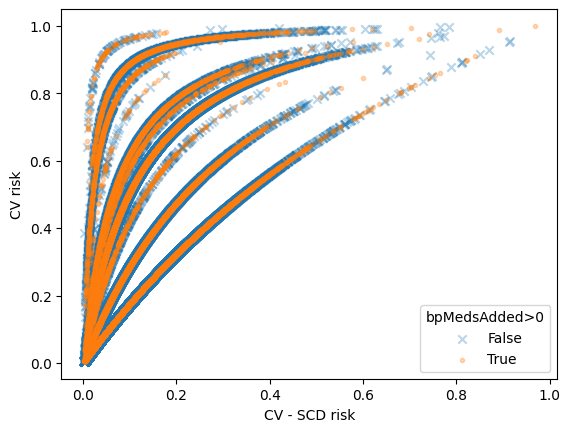

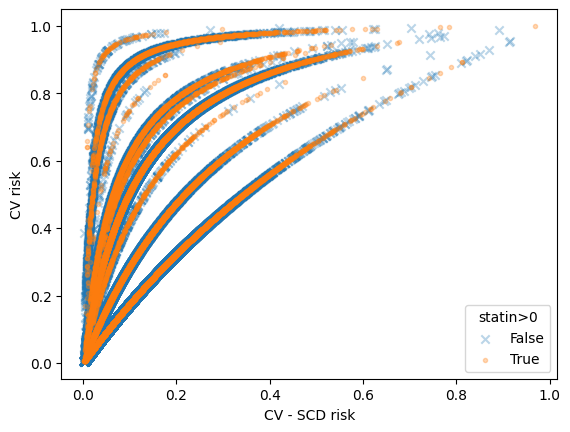

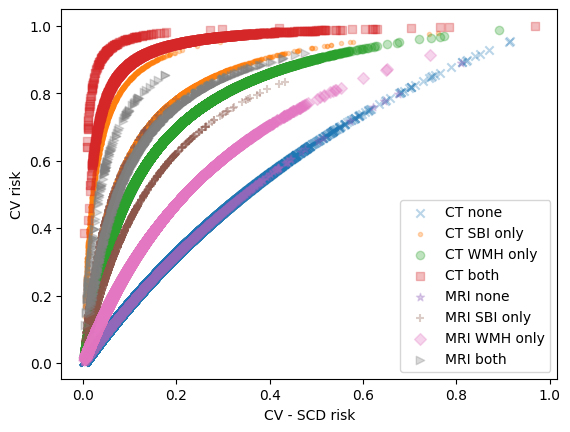

In [13]:
print_treatment_strategy_higher_order_information(tr.treatedPop)